In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from time import time
from functools import reduce
import matplotlib.pyplot as plt

# Sklearn
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Own Liberay


# PCR - Principal component regression

## Data processing


In [4]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

### 1. Load data

In [6]:
# Import features
file_path = 'Merged_dataset.csv'
df = pd.read_csv("merged_dataset.csv", sep=";", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.shape

(156, 184)

In [7]:
y = df.iloc[:, 0]   # første kolonne = inflation
X = df.iloc[:, 1:]  # resten = forklarende variable

# Tjek dimensioner
print("y shape:", y.shape)
print("X shape:", X.shape)

y shape: (156,)
X shape: (156, 183)


### 2. Imputer manglende værdier

In [9]:
imputer = SimpleImputer(strategy="median")  # Eller "median"

X_imputed = imputer.fit_transform(X)  # Imputer NaN i hele datasættet

# Konverter tilbage til DataFrame med kolonnenavne
X = pd.DataFrame(X_imputed, columns=X.columns, index = df.index)

### 3. Standardiser data 

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Simple PCR

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Step 1: PCA

In [15]:
#PCA uden at specificere antal komponenter
pca = PCA().fit(X_train)

# Kumulativ forklaring
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Vælg hvor mange komponenter der skal til for fx 95% forklaring
n_component = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Valgte {n_component} komponenter for at forklare mindst 95% af variansen")

Valgte 15 komponenter for at forklare mindst 95% af variansen


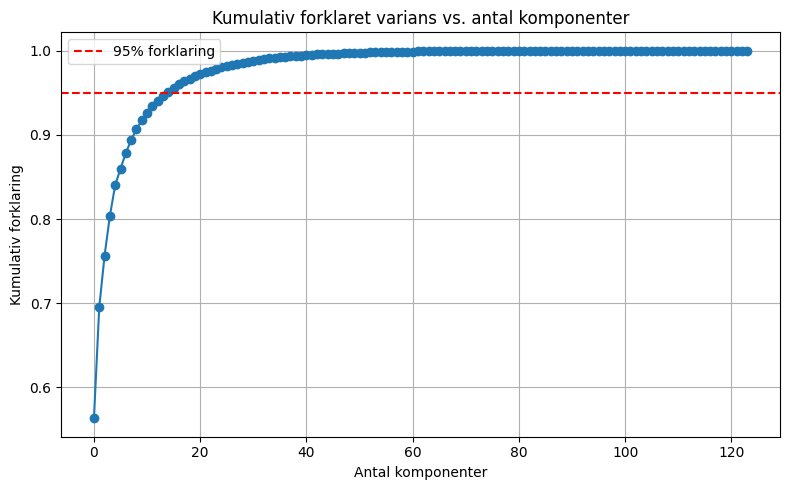

In [16]:
# Beregn kumulativ varians forklaret
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% forklaring')
plt.xlabel('Antal komponenter')
plt.ylabel('Kumulativ forklaring')
plt.title('Kumulativ forklaret varians vs. antal komponenter')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Step 2: Linear Regression

In [18]:
# Fit regression på de komponenter
X_pca = pca.fit_transform(X_scaled)
reg = LinearRegression().fit(X_pca, y)

reg

LinearRegression()

In [19]:
# Konstruér DataFrame af X + y
df_corr = pd.DataFrame(X_scaled, columns=X.columns)
df_corr['Inflation'] = y.values  # eller bare y hvis det er en Series

# Plot korrelationer
corr = df_corr.corr()['Inflation'].sort_values(key=abs, ascending=False)

# Top 20 mest korrelerede
print(corr.head(20))

Inflation                                                                 1.000000
inflation_rolling_mean3                                                   0.983953
inflation_lag1                                                            0.977439
inflation_lag2                                                            0.939677
inflation_lag3                                                            0.895486
Priser i dag, sammenlignet med for et år siden                            0.861921
04.5 Elektricitet, gas og andet brændsel                                  0.845643
Anskaffelse af større forbrugsgoder, fordelagtigt for øjeblikket         -0.795627
Forbrugertillidsindikatoren                                              -0.794775
Familiens økonomiske  situation om et år, sammenlignet med i dag         -0.779686
Anskaffelse af større forbrugsgoder, inden for de næste 12 mdr.          -0.761351
Familiens økonomiske situation i dag, sammenlignet med for et år siden   -0.754792
Danm

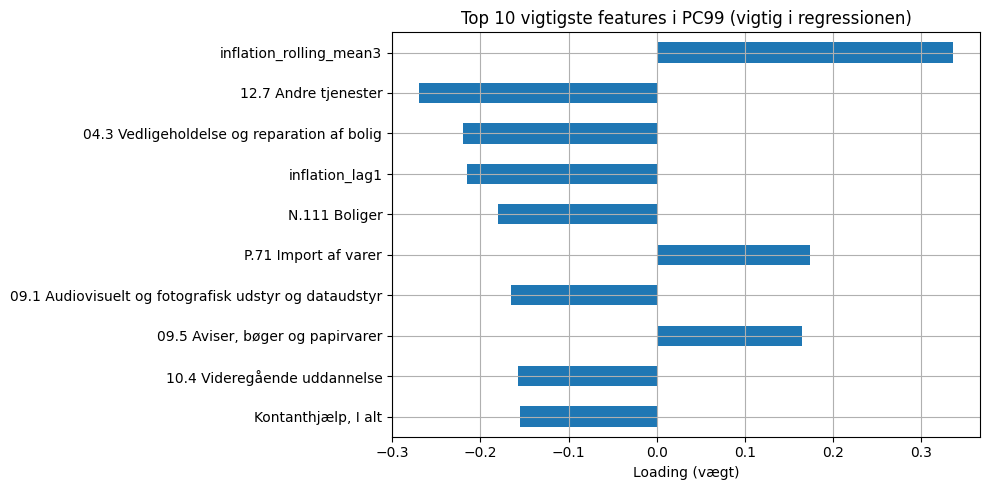

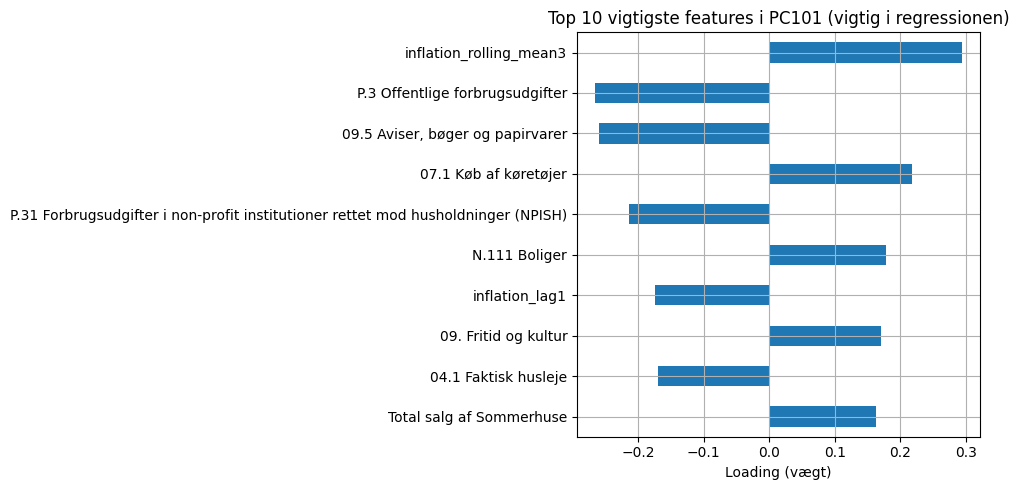

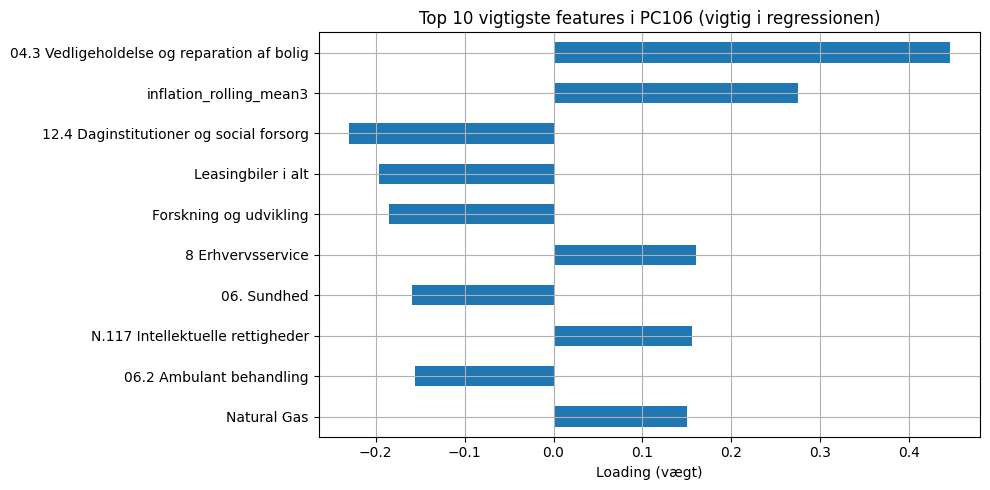

In [20]:
# Step 1: Find de vigtigste PC’er (efter regression på y)
coefs = np.abs(reg.coef_)  # Brug absolut værdi af koefficienter
important_pcs = np.argsort(coefs)[::-1][:3]  # Vælg top 3 vigtigste PC'er

# Step 2: Lav barplots over top 10 features i hver vigtig PC
for i in important_pcs:
    pc_loadings = pd.Series(pca.components_[i], index=X.columns)
    top_features = pc_loadings.abs().sort_values(ascending=False).head(10)
    top_features_signed = pc_loadings[top_features.index]  # Bevar fortegn

    # Plot
    plt.figure(figsize=(10, 5))
    top_features_signed.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 vigtigste features i PC{i+1} (vigtig i regressionen)")
    plt.xlabel("Loading (vægt)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
# 1. Definér antal hovedkomponenter (du kan vælge fx 10 eller bruge forklaring)
n_components = n_component

# 2. Lav PCR pipeline
pcr_model = Pipeline([
    ("pca", PCA(n_components=n_components)),
    ("reg", LinearRegression())
])

# 3. Træn modellen
pcr_model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=15)), ('reg', LinearRegression())])

In [22]:
# Forudsig
y_pred = pcr_model.predict(X_test)

# Evaluer
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MSE: 0.23
R²: 0.93


In [23]:
# 1. Træk ud delene fra pcr_model
pca = pcr_model.named_steps["pca"]
reg = pcr_model.named_steps["reg"]

# 2. Beregn "vigtighed" af hver original feature
# → Multiplicer PCA-komponentvægtninger (loadings) med regressionens koefficienter
# Dette transformerer koefficienter tilbage til original feature space

# shape: (n_features,)
pseudo_importance = np.dot(pca.components_.T, reg.coef_)

# 3. Pak det i en DataFrame
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": np.abs(pseudo_importance)  # evt. brug abs for styrke
}).sort_values(by="Importance", ascending=False)

# 4. Vis top 10
importance_df.head(10)

,Feature,Importance
166,inflation_lag1,0.188804
169,inflation_rolling_mean3,0.186299
135,Korrektioner,0.175603
167,inflation_lag2,0.172107
168,inflation_lag3,0.148844
111,"Priser i dag, sammenlignet med for et år siden",0.132048
10,"04.5 Elektricitet, gas og andet brændsel",0.120309
104,Beskæftigede Kvinder,0.102122
89,Antal Skilsmisser,0.096164
86,Total salg af Ejerlejligheder,0.094322


# Simple Forecast

In [25]:
# Parametre
forecast_horizons = 12
# n_components = 15  # <- hvor mange PCA-komponenter du vil bruge

pcr_models = {}

# Træn én model per horisont
for h in range(forecast_horizons):
    print(f"\n=== Horizon {h+1} ===")

    y_shifted = y.shift(-h).dropna()
    X_train = X_scaled[:len(y_shifted)]  # Brug skaleret X
    y_train = y_shifted

    # Automatisk valg af antal komponenter
    pca = PCA().fit(X_train)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumvar >= 0.99) + 1
        
        
    # Byg PCR pipeline
    model = Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("reg", LinearRegression())
    ])

    model.fit(X_train, y_train)
    pcr_models[h] = model

    print(f"Antal træningsobservationer: {len(y_train)}")
    print(f"PCA-komponenter brugt: {n_components}")

# Forudsig fra sidste observation
latest_data_df = X.iloc[[-1]]
latest_data_scaled = scaler.transform(latest_data_df)

pcr_forecasts = {}

for h in range(forecast_horizons):
    forecast = pcr_models[h].predict(latest_data_scaled)
    pcr_forecasts[h] = forecast[0]


=== Horizon 1 ===
Antal træningsobservationer: 156
PCA-komponenter brugt: 35

=== Horizon 2 ===
Antal træningsobservationer: 155
PCA-komponenter brugt: 35

=== Horizon 3 ===
Antal træningsobservationer: 154
PCA-komponenter brugt: 35

=== Horizon 4 ===
Antal træningsobservationer: 153
PCA-komponenter brugt: 35

=== Horizon 5 ===
Antal træningsobservationer: 152
PCA-komponenter brugt: 35

=== Horizon 6 ===
Antal træningsobservationer: 151
PCA-komponenter brugt: 35

=== Horizon 7 ===
Antal træningsobservationer: 150
PCA-komponenter brugt: 35

=== Horizon 8 ===
Antal træningsobservationer: 149
PCA-komponenter brugt: 35

=== Horizon 9 ===
Antal træningsobservationer: 148
PCA-komponenter brugt: 35

=== Horizon 10 ===
Antal træningsobservationer: 147
PCA-komponenter brugt: 35

=== Horizon 11 ===
Antal træningsobservationer: 146
PCA-komponenter brugt: 35

=== Horizon 12 ===
Antal træningsobservationer: 145
PCA-komponenter brugt: 34


In [26]:
pcr_forecasts

{0: 1.8918675657660644,
 1: 2.364263134163708,
 2: 2.7812995569776886,
 3: 2.760473423287066,
 4: 2.6596144241258672,
 5: 2.698282995110454,
 6: 2.5733883908463326,
 7: 2.799699858580351,
 8: 2.7753601322429495,
 9: 2.812894835574331,
 10: 2.670648358444123,
 11: 3.5465232491980645}

# Forsøg 2

In [28]:
def PCR_Forecaster(X, y, forecast_horizon, last_observation_date, scaler, variance_threshold=0.95, verbose=True):
    """
    Forecast inflation using Principal Component Regression (PCR) per forecast horizon.
    
    Args:
        X: DataFrame of predictors
        y: Series of target
        forecast_horizon: int, number of months ahead
        last_observation_date: str or Timestamp, point to forecast from
        scaler: fitted StandardScaler on training data
        variance_threshold: float, % of explained variance to retain (default: 0.95)
        verbose: print training info
    """

    # Trim data til real-time
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]

    X_scaled = scaler.transform(X)
    
    pcr_models = {}

    for h in range(forecast_horizon):
        if verbose:
            print(f"\n=== Horisont h={h} ===")

        y_shifted = y.shift(-h).dropna()
        X_train = X_scaled[:len(y_shifted)]
        y_train = y_shifted

        # Automatisk valg af antal komponenter
        pca = PCA().fit(X_train)
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumvar >= variance_threshold) + 1

        if verbose:
            print(f"Forklaret varians (k={n_components}): {cumvar[n_components-1]:.2%}")
            
        # PCR pipeline
        model = Pipeline([
            ("pca", PCA(n_components=n_components)),
            ("reg", LinearRegression())
        ])

        model.fit(X_train, y_train)
        pcr_models[h] = model

        if verbose:
            print(f"Træningsobs: {len(y_train)} | Komponenter: {n_components}")

    # Forudsig fra X_t
    try:
        X_t = X.loc[[last_observation_date]]
    except KeyError:
        X_t = X.iloc[[-1]]
        if verbose:
            print(f"Dato {last_observation_date} ikke i X, bruger {X.index[-1]} i stedet.")

    X_t_scaled = scaler.transform(X_t)

    # Forudsig
    pcr_forecasts = {}
    for h in range(forecast_horizon):
        forecast = pcr_models[h].predict(X_t_scaled)
        pcr_forecasts[h] = forecast[0]

    # Lav datoer
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in pcr_forecasts.keys()]

    #  Print datoer for de forudsagte måneder
    print("\nForudsagte måneder:")
    for date in forecast_dates:
        print(date.strftime("%Y-%m"))
        
    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(pcr_forecasts.values()),
        "Horizon": [h + 1 for h in pcr_forecasts.keys()]
    })

    return forecast_df


In [111]:
# Lav forecast fra sidste kendte måned
forecast_df = PCR_Forecaster(
    X=X,
    y=y,
    forecast_horizon=12,
    last_observation_date="2024-12-01",
    scaler=scaler,
    variance_threshold=0.995
)


=== Horisont h=0 ===
Forklaret varians (k=45): 99.53%
Træningsobs: 156 | Komponenter: 45

=== Horisont h=1 ===
Forklaret varians (k=45): 99.52%
Træningsobs: 155 | Komponenter: 45

=== Horisont h=2 ===
Forklaret varians (k=44): 99.51%
Træningsobs: 154 | Komponenter: 44

=== Horisont h=3 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 153 | Komponenter: 44

=== Horisont h=4 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 152 | Komponenter: 44

=== Horisont h=5 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 151 | Komponenter: 44

=== Horisont h=6 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 150 | Komponenter: 44

=== Horisont h=7 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 149 | Komponenter: 44

=== Horisont h=8 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 148 | Komponenter: 44

=== Horisont h=9 ===
Forklaret varians (k=44): 99.53%
Træningsobs: 147 | Komponenter: 44

=== Horisont h=10 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 146 | Komponenter: 44

=== Hori

In [30]:
forecast_df

,Dato,Inflationsforecast,Horizon
0,2025-01-01,1.838266,1
1,2025-02-01,2.307344,2
2,2025-03-01,2.719857,3
3,2025-04-01,2.940492,4
4,2025-05-01,2.738915,5
5,2025-06-01,2.698520,6
6,2025-07-01,2.508688,7
7,2025-08-01,2.519512,8
8,2025-09-01,2.004771,9
9,2025-10-01,2.618342,10


# Implement of a rolling window

In [106]:
def PCR_Forecaster_Rolling(X, y, forecast_horizon, start_date, end_date, scaler, window_length=108, variance_threshold=0.95, verbose=True):
    """
    Rolling PCR forecast for inflation over multiple months.
    
    Args:
        X: DataFrame of predictors
        y: Series of target variable
        forecast_horizon: int, number of months ahead to forecast (e.g. 12)
        start_date: str or Timestamp, first forecast date
        end_date: str or Timestamp, last forecast date
        scaler: a fitted sklearn scaler (on full data or a reference window)
        window_length: int, number of time steps in rolling window (default 108 = 9 years of monthly data)
        variance_threshold: float, fraction of variance to retain in PCA
        verbose: bool, print info
    """
    all_forecasts = []

    # Loop over hver måned fra start til slut
    rolling_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

    for current_date in rolling_dates:
        if verbose:
            print(f"\n🔁 Rolling forecast pr. {current_date.strftime('%Y-%m')}")

        # Begræns træningsdata til rolling window op til current_date
        X_sub = X.loc[:current_date].iloc[-window_length:]
        y_sub = y.loc[:current_date].iloc[-window_length:]

        # Fit scaler på træningsdata (ingen datalæk)
        X_sub_scaled = pd.DataFrame(scaler.transform(X_sub), index=X_sub.index, columns=X_sub.columns)

        pcr_models = {}

        # Træn en model per horisont
        for h in range(forecast_horizon):
            y_shifted = y_sub.shift(-h).dropna()
            X_train = X_sub_scaled.iloc[:len(y_shifted)]
            y_train = y_shifted

            # PCA: vælg antal komponenter
            pca = PCA().fit(X_train)
            cumvar = np.cumsum(pca.explained_variance_ratio_)
            n_components = np.argmax(cumvar >= variance_threshold) + 1

            # Pipeline
            model = Pipeline([
                ("pca", PCA(n_components=n_components)),
                ("reg", LinearRegression())
            ])
            model.fit(X_train, y_train)
            pcr_models[h] = model

        # Forudsig fra sidste observation i vinduet
        X_t = X.loc[[current_date]]
        X_t_scaled = pd.DataFrame(scaler.transform(X_t), index=X_t.index, columns=X_t.columns)

        for h in range(forecast_horizon):
            forecast = pcr_models[h].predict(X_t_scaled)[0]
            forecast_date = current_date + pd.DateOffset(months=h+1)

            all_forecasts.append({
                "Dato": forecast_date,
                "Forecast_made": current_date,
                "Horizon": h+1,
                "Inflationsforecast": forecast
            })

    forecast_df = pd.DataFrame(all_forecasts)
    return forecast_df


In [110]:
rolling_pcr_df = PCR_Forecaster_Rolling(
    X=X,
    y=y,
    forecast_horizon=12,
    start_date="2015-01-01",
    end_date="2023-12-01",
    scaler=scaler,
    window_length=108,
    variance_threshold=0.95,
    verbose=True
)



🔁 Rolling forecast pr. 2015-01

🔁 Rolling forecast pr. 2015-02

🔁 Rolling forecast pr. 2015-03

🔁 Rolling forecast pr. 2015-04

🔁 Rolling forecast pr. 2015-05

🔁 Rolling forecast pr. 2015-06

🔁 Rolling forecast pr. 2015-07

🔁 Rolling forecast pr. 2015-08

🔁 Rolling forecast pr. 2015-09

🔁 Rolling forecast pr. 2015-10

🔁 Rolling forecast pr. 2015-11

🔁 Rolling forecast pr. 2015-12

🔁 Rolling forecast pr. 2016-01

🔁 Rolling forecast pr. 2016-02

🔁 Rolling forecast pr. 2016-03

🔁 Rolling forecast pr. 2016-04

🔁 Rolling forecast pr. 2016-05

🔁 Rolling forecast pr. 2016-06

🔁 Rolling forecast pr. 2016-07

🔁 Rolling forecast pr. 2016-08

🔁 Rolling forecast pr. 2016-09

🔁 Rolling forecast pr. 2016-10

🔁 Rolling forecast pr. 2016-11

🔁 Rolling forecast pr. 2016-12

🔁 Rolling forecast pr. 2017-01

🔁 Rolling forecast pr. 2017-02

🔁 Rolling forecast pr. 2017-03

🔁 Rolling forecast pr. 2017-04

🔁 Rolling forecast pr. 2017-05

🔁 Rolling forecast pr. 2017-06

🔁 Rolling forecast pr. 2017-07

🔁 Rolli

In [114]:
rolling_pcr_df

,Dato,Forecast_made,Horizon,Inflationsforecast
0,2015-02-01,2015-01-01,1,0.160344
1,2015-03-01,2015-01-01,2,0.611456
2,2015-04-01,2015-01-01,3,0.574183
3,2015-05-01,2015-01-01,4,0.830185
4,2015-06-01,2015-01-01,5,0.937443
...,...,...,...,...
1291,2024-08-01,2023-12-01,8,1.196836
1292,2024-09-01,2023-12-01,9,1.181599
1293,2024-10-01,2023-12-01,10,1.333835
1294,2024-11-01,2023-12-01,11,2.241996
